## Import Libraries & Load Dataset

In [1]:
import os
import glob
import pickle
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

## Houses Price Dataset

In [2]:
data = pd.read_csv("HousesDataset/HousesInfo.txt",header=None,sep=" ",names=["Bedroom","Bathroom","Area","Zipcode","Price"])
data.head()

,Bedroom,Bathroom,Area,Zipcode,Price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [3]:
images = []
for i in data.index.values:
    image = []
    for img in glob.glob(os.path.join(f"HousesDataset/{i+1}_*")):
        img = cv2.imread(img)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(32,32))
        image.append(img)
    mask = np.zeros((64,64,3),np.uint8)
    mask[:32,:32] = image[0]
    mask[:32,32:] = image[1]
    mask[32:,:32] = image[2]
    mask[32:,32:] = image[3]
    images.append(mask)
images = np.array(images)

# Preprocessing

In [4]:
Data_Train, Data_Test, Image_Train, Image_Test = train_test_split(data,images,test_size=0.1)

## Scaling

### StandardScaler

In [5]:
SS = StandardScaler()
X_Train = SS.fit_transform(Data_Train[["Bedroom","Bathroom","Area"]])
X_Test = SS.transform(Data_Test[["Bedroom","Bathroom","Area"]])
Y_Train =  Data_Train["Price"]
Y_Test = Data_Test["Price"]

## Convert Categorical to Numerical
### OHE

In [6]:
lb = LabelBinarizer()
lb.fit(data["Zipcode"])
X_Train_zip = lb.transform(Data_Train["Zipcode"])
X_Test_zip = lb.transform(Data_Test["Zipcode"])

In [7]:
X_Train = np.concatenate((X_Train,X_Train_zip),axis=1)
X_Test = np.concatenate((X_Test,X_Test_zip),axis=1)

## Model for image

In [8]:
model1 = Sequential()
model1.add(Conv2D(64,(3,3),padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(BatchNormalization(axis=-1))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(64,(3,3),padding="same",activation="relu"))
model1.add(BatchNormalization(axis=-1))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(128,(3,3),padding="same",activation="relu"))
model1.add(BatchNormalization(axis=-1))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(128,(3,3),padding="same",activation="relu"))
model1.add(BatchNormalization(axis=-1))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(32,activation="relu"))
model1.add(BatchNormalization(axis=-1))
model1.add(Dropout(0.5))
model1.add(Dense(16,activation="relu"))

## Model for Dataframe

In [9]:
model2 = Sequential()
model2.add(Dense(32,activation="relu",input_dim=52))
model2.add(Dropout(0.5))
model2.add(Dense(16,activation="relu"))

# Model API

In [10]:
combined_model = concatenate([model2.output,model1.output])
dense1 = Dense(32,activation="relu")(combined_model)
dense2 = Dense(1,activation="linear")(dense1)
model = Model(inputs=[model2.input,model1.input],outputs=dense2)

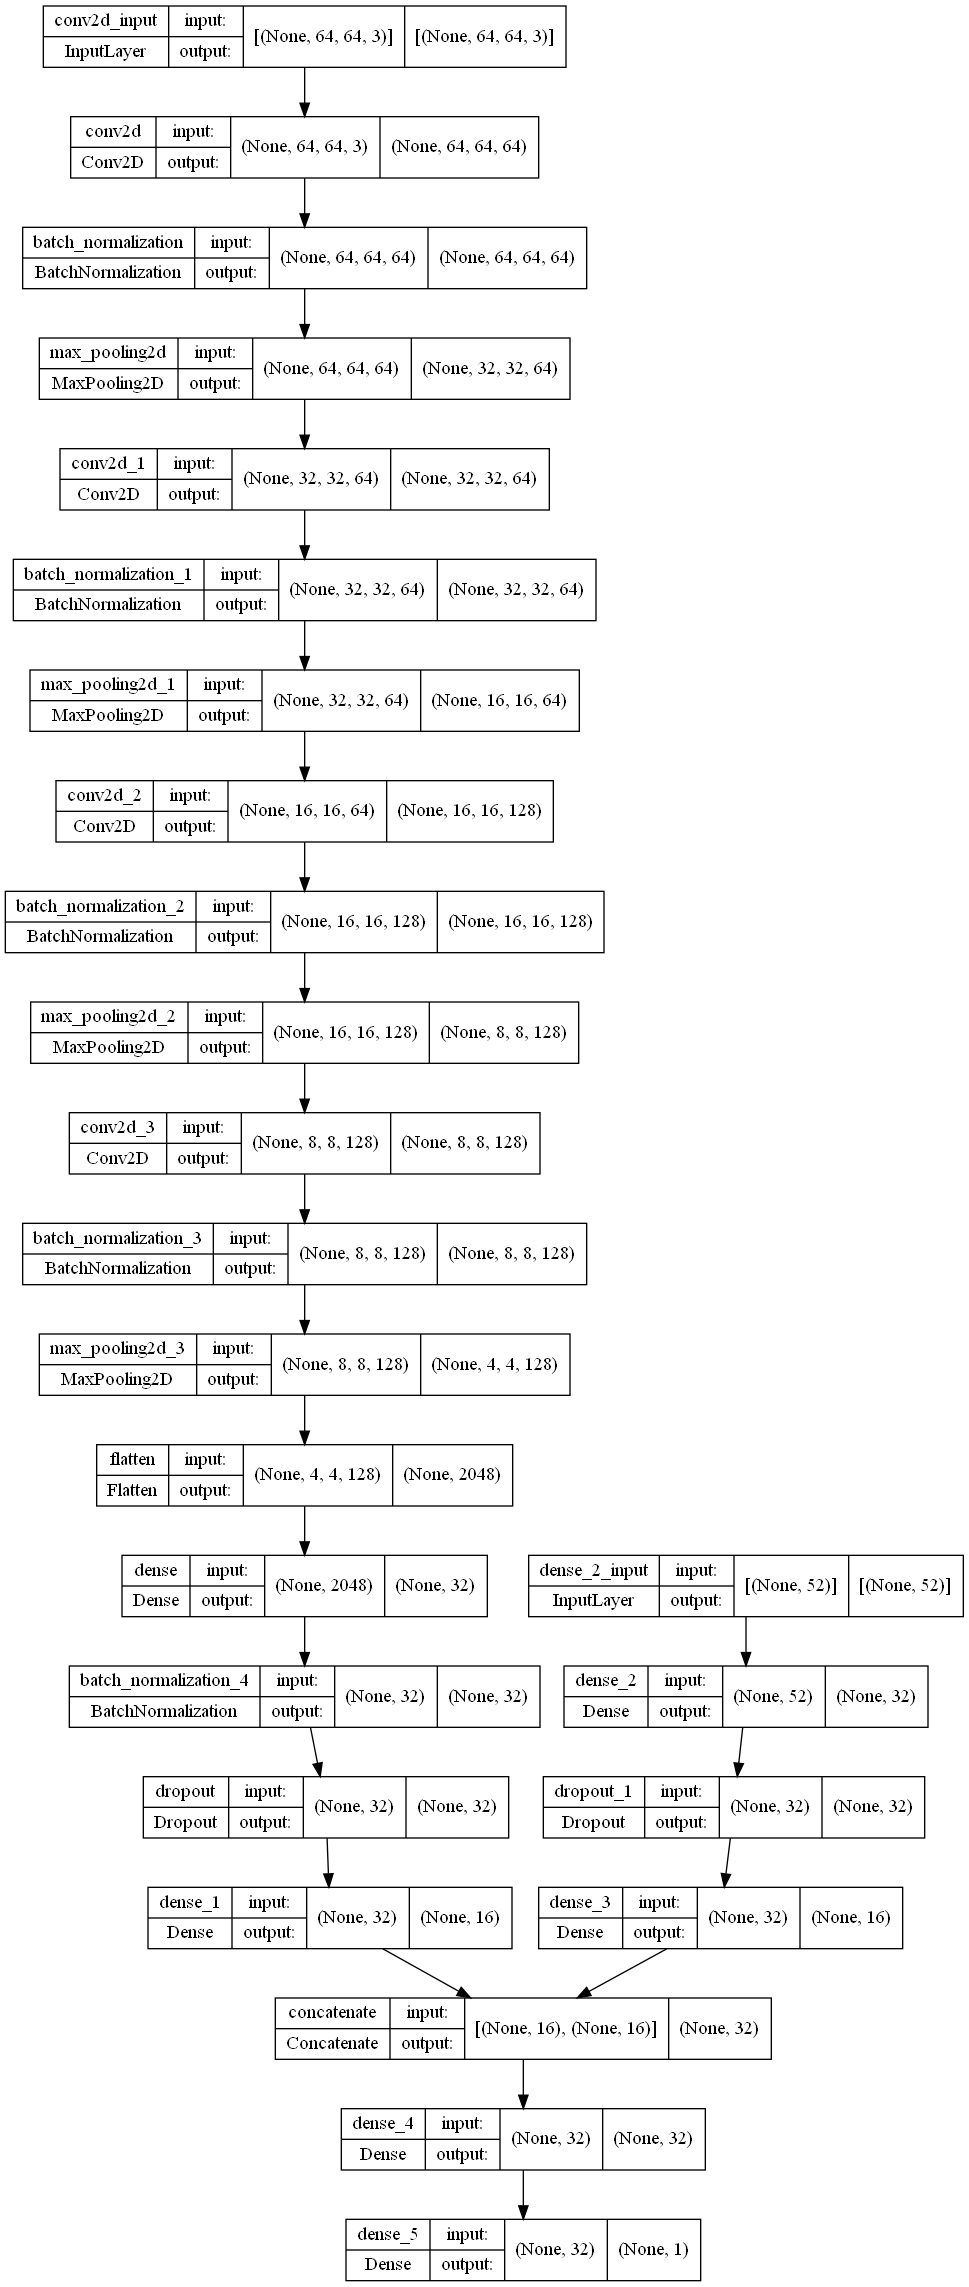

In [11]:
plot_model(model,show_shapes=True)

In [11]:
model.compile(optimizer="adam",loss="mean_absolute_error")
checkpoint = ModelCheckpoint("houseprice.h5",monitor="val_loss",mode="min",save_best_only=True)

In [12]:
history = model.fit([X_Train,Image_Train],
                    Y_Train,
                    validation_data=([X_Test,Image_Test],Y_Test),
                    epochs=150,
                    batch_size=8,
                    callbacks=[checkpoint])

Epoch 1/150
61/61 [==============================] - 7s 97ms/step - loss: 599835.1250 - val_loss: 496030.3750
Epoch 2/150
61/61 [==============================] - 5s 80ms/step - loss: 599814.8750 - val_loss: 495992.0625
Epoch 3/150
61/61 [==============================] - 5s 81ms/step - loss: 599707.7500 - val_loss: 495472.5938
Epoch 4/150
61/61 [==============================] - 5s 89ms/step - loss: 599301.3125 - val_loss: 494698.2812
Epoch 5/150
61/61 [==============================] - 5s 88ms/step - loss: 598198.0625 - val_loss: 492688.8438
Epoch 6/150
61/61 [==============================] - 5s 90ms/step - loss: 595817.5000 - val_loss: 488715.4062
Epoch 7/150
61/61 [==============================] - 5s 89ms/step - loss: 591527.3125 - val_loss: 478581.7188
Epoch 8/150
61/61 [==============================] - 6s 91ms/step - loss: 584177.1250 - val_loss: 436868.5938
Epoch 9/150
61/61 [==============================] - 5s 87ms/step - loss: 573448.8750 - val_loss: 458692.5312
Epoch 10/1

Epoch 75/150
61/61 [==============================] - 5s 82ms/step - loss: 156420.7031 - val_loss: 193825.4688
Epoch 76/150
61/61 [==============================] - 5s 81ms/step - loss: 164030.0312 - val_loss: 249163.1406
Epoch 77/150
61/61 [==============================] - 5s 82ms/step - loss: 153461.0000 - val_loss: 175091.7344
Epoch 78/150
61/61 [==============================] - 5s 84ms/step - loss: 152117.4531 - val_loss: 172121.3750
Epoch 79/150
61/61 [==============================] - 5s 84ms/step - loss: 149218.8750 - val_loss: 167480.8906
Epoch 80/150
61/61 [==============================] - 5s 82ms/step - loss: 159024.1562 - val_loss: 190581.8281
Epoch 81/150
61/61 [==============================] - 5s 82ms/step - loss: 149030.5312 - val_loss: 196614.5625
Epoch 82/150
61/61 [==============================] - 5s 84ms/step - loss: 149339.1094 - val_loss: 163186.7031
Epoch 83/150
61/61 [==============================] - 5s 82ms/step - loss: 163910.5625 - val_loss: 179519.1406
E

In [13]:
with open("StandardScaler","wb") as f:
    pickle.dump(SS,f)
with open("LabelBinarizer","wb") as f:
    pickle.dump(lb,f)

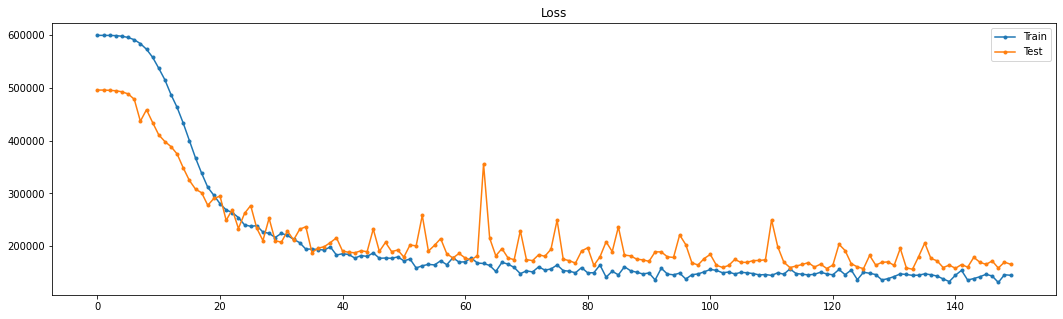

In [14]:
fig = plt.figure(figsize=(18,5))
plt.title("Loss")
plt.plot(history.history["loss"],label="Train",marker=".")
plt.plot(history.history["val_loss"],label="Test",marker=".")
plt.legend()
plt.show()